In [290]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
from skimage import feature
from skimage import filters
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage.color import rgb2gray

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer , make_column_selector

import random
import numpy as np
import cv2
from PIL import Image
import pandas as pd



# 1 Dataset

In [ ]:
# Constants



In [160]:
# functions

def as_gray(image_filter, image, *args, **kwargs):
    gray_image = rgb2gray(image)
    return image_filter(gray_image, *args, **kwargs)

def to_greyscale (rgbimage_np):  # (x, y, 3)
    # NumPy array to a Pillow Image object
    # print (rgbimage_np.shape)
    rgbimage_pil = Image.fromarray(rgbimage_np)
    grayimage_pil = rgbimage_pil.convert('L')   
    # print (np.array(grayimage_pil).shape) 
    return np.array(grayimage_pil) # (x, y)


In [161]:
# The Street View House Numbers (SVHN) Dataset  (Format 2: Cropped Digits: train_32x32.mat, test_32x32.mat , extra_32x32.mat (Note: for non-commercial use only) )
# Character level ground truth in an MNIST-like format.
# All digits have been resized to a fixed resolution of 32-by-32 pixels. 
# The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions. 
# Nevertheless this preprocessing introduces some distracting digits to the sides of the digit of interest.
# Loading the .mat files creates 2 variables: X which is a 4-D matrix containing the images, and y which is a vector of class labels. 
# To access the images, X(:,:,:,i) gives the i-th 32-by-32 RGB image, with class label y(i). 
#  73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data 

test_mat = loadmat('test_32x32.mat')
test_images = test_mat['X'] # (32, 32, 3, 26032)
test_labels = test_mat['y'].ravel() # (26032,) 

train_mat = loadmat('train_32x32.mat')
train_images = train_mat['X'] # (32, 32, 3, 73257)
train_labels = train_mat['y'].ravel() # (73257,)


del test_mat
del train_mat
# to get the image and extract stuff
#for i in range(100):
#    plt.figure()
#    train_image = train_images[:,:,:,i+30]
#    plt.imshow(train_image)
#    plt.title(str(train_labels[i+30,0])+ " with iteration " + str(i+30))


# 2 Feature Extraction
## 2.1.1 Challenging cases

In [ ]:
subset_size = 10000
all_possible_arrays = range(train_labels.size)
subset =  random.sample(all_possible_arrays,subset_size)
train_images_subset = train_images[:,:,:,subset]
train_labels_subset = train_labels[subset] 


# Variables

printed_images = [31,119,81,99]
x_images       = [1,1,0,0]
y_images       = [1,0,1,0]

edge_dict={}
edge_dict_full={}

<Figure size 640x480 with 0 Axes>

/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig()

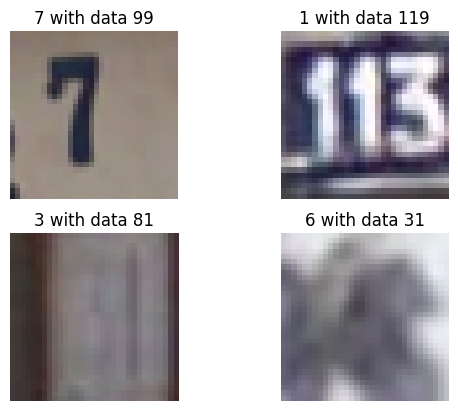

In [5]:
# normal image (32, 32,3)
plt.figure()
fig, axs = plt.subplots(2, 2)
plt.title("Original image")
for i in range(len(printed_images)):
    show_image = train_images[:,:,:,printed_images[i]] 
    axs[y_images[i],x_images[i]].imshow(show_image)
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


##  2.1.2 Five techniques
### Grayscale

In [ ]:
# grayscale
name = "grayscale"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean

print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = to_greyscale(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(to_greyscale(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

### Edge Detection

In [ ]:
# farid edge magnitude using the Farid transform.
name = "farid"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean

@adapt_rgb(as_gray)
def farid_gray(image):
    return filters.farid(image)

def farid(image):
    return farid_gray(to_greyscale((image)))

print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = farid(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(farid(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# laplace operator edge detector
name = "laplace"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def laplace_gray(image):
    return filters.laplace(image)

def laplace(image):
    return laplace_gray(to_greyscale((image)))


print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = laplace(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(laplace(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# prewitt filter edge detector
name = "prewitt"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def prewitt_gray(image):
    return filters.prewitt(image)

def prewitt(image):
    return prewitt_gray(to_greyscale((image)))


print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = prewitt(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(prewitt(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# roberts operator edge detector
name = "roberts"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def roberts_gray(image):
    return filters.roberts(image)

def roberts(image):
    return roberts_gray(to_greyscale((image)))


print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = roberts(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(roberts(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# scharr operator edge detector
name = "scharr"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def scharr_gray(image):
    return filters.scharr(image)

def scharr(image):
    return scharr_gray(to_greyscale((image)))


print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = scharr(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(scharr(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# Sobel filter edge detector
name = "sobel"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def sobel_gray(image):
    return filters.sobel(image)

def sobel(image):
    return sobel_gray(to_greyscale((image)))



print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = sobel(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(sobel(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# canny image detector
name = "canny"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def canny_gray(image):
    return feature.canny(image)

def canny(image):
    return canny_gray(to_greyscale((image)))



print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = canny(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(canny(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

### LBP

In [ ]:
# lpb  local binary pattern
radius_of_circle = 3 #     Radius of circle (spatial resolution of the operator).
no_of_neighbor_set_points = 9  * radius_of_circle # Number of circularly symmetric neighbor set points (quantization of the angular space).
name = "lpb"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def lpb_gray(image):
    return feature.local_binary_pattern(image, no_of_neighbor_set_points, radius_of_circle, method='default')

def lpb(image):
    return lpb_gray(to_greyscale((image)))

print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = lpb(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(lpb(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# lpb_ror  local binary pattern
radius_of_circle = 3 #     Radius of circle (spatial resolution of the operator).
no_of_neighbor_set_points = 9  * radius_of_circle # Number of circularly symmetric neighbor set points (quantization of the angular space).
name = "lpb_ror"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def lpb_ror_gray(image):
    return feature.local_binary_pattern(image, no_of_neighbor_set_points, radius_of_circle, method='ror')

def lpb_ror(image):
    return lpb_ror_gray(to_greyscale((image)))

print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = lpb_ror(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(lpb_ror(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# ulpb Uniform local binary pattern
radius_of_circle = 3 #     Radius of circle (spatial resolution of the operator).
no_of_neighbor_set_points = 9  * radius_of_circle # Number of circularly symmetric neighbor set points (quantization of the angular space).
name = "ulpb"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def ulpb_gray(image):
    return feature.local_binary_pattern(image, no_of_neighbor_set_points, radius_of_circle, method='uniform')

def ulpb(image):
    return ulpb_gray(to_greyscale((image)))

print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = ulpb(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(ulpb(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# nri_uniform Uniform local binary pattern
radius_of_circle = 3 #     Radius of circle (spatial resolution of the operator).
no_of_neighbor_set_points = 9  * radius_of_circle # Number of circularly symmetric neighbor set points (quantization of the angular space).
name = "nulpb"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def nulpb_gray(image):
    return feature.local_binary_pattern(image, no_of_neighbor_set_points, radius_of_circle, method='nri_uniform')

def nulpb(image):
    return nulpb_gray(to_greyscale((image)))

print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = nulpb(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(nulpb(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

### Corner Detection

In [ ]:
# Compute fast corner measure response image
minimum_number_of_consecutive_pixels=1
threshold=0.05
name = "fast_corner"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def fast_corner_gray(image):
    return feature.corner_fast(image, minimum_number_of_consecutive_pixels, threshold)

def fast_corner(image):
    return fast_corner_gray(to_greyscale((image)))

print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = fast_corner(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(fast_corner(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# Compute harris corner measure response image
k=0.9
eps=1e-06
sigma=5
name = "harris_corner"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def harris_corner_gray(image):
    return feature.corner_harris(image, k, eps, sigma)

def harris_corner(image):
    return harris_corner_gray(to_greyscale((image)))


print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = harris_corner(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(harris_corner(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# Compute Kitchen and Rosenfeld corner measure response image
mode='reflect'
cval=0
name = "kitchen_rosenfeld_corner"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def kitchen_rosenfeld_corner_gray(image):
    return feature.corner_kitchen_rosenfeld(image, mode, cval)

def kitchen_rosenfeld_corner(image):
    return kitchen_rosenfeld_corner_gray(to_greyscale((image)))


print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = kitchen_rosenfeld_corner(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(kitchen_rosenfeld_corner(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# Compute moravec corner measure response image
window_size=1
name = "moravec_corner"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def moravec_corner_gray(image):
    return feature.corner_moravec(image, window_size)

def moravec_corner(image):
    return moravec_corner_gray(to_greyscale((image)))


print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = moravec_corner(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(moravec_corner(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# Compute Shi-Tomasi (Kanade-Tomasi) corner measure response image
sigma=1
name = "shi_tomasi_corner"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def shi_tomasi_corner_gray(image):
    return feature.corner_shi_tomasi(image, sigma)

def shi_tomasi_corner(image):
    return shi_tomasi_corner_gray(to_greyscale((image)))


print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = shi_tomasi_corner(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(shi_tomasi_corner(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

### Other Filters

In [ ]:
# Hybrid Hessian filter
sigmas =range(1, 10, 2) # 0.1   or 1
name = "hessian"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def hessian_gray(image):
    return filters.hessian(image, sigmas,mode='constant')

def hessian(image):
    return hessian_gray(to_greyscale((image)))


print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = hessian(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(hessian(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# Hybrid Meijering  filter
sigmas =range(1, 10, 2) # 0.1   or 1
name = "meijering"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def meijering_gray(image):
    return filters.meijering(image, sigmas)

def meijering(image):
    return meijering_gray(to_greyscale((image)))



print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = meijering(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(meijering(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# Hybrid sato  filter
sigmas =range(1, 10, 2) # 0.1   or 1
name = "sato"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def sato_gray(image):
    return filters.sato(image, sigmas, mode='constant')

def sato(image):
    return sato_gray(to_greyscale((image)))



print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = sato(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(sato(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# Hybrid frangi  filter
sigmas =range(1, 10, 2) # 0.1   or 1
name = "frangi"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def frangi_gray(image):
    return filters.frangi(image, sigmas)

def frangi(image):
    return frangi_gray(to_greyscale((image)))



print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = frangi(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(frangi(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# gabor  filter
name = "gabor"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def gabor_gray(image):
    show_image_real,show_image_imaginary = filters.gabor(image, frequency=0.1)
    return show_image_real

def gabor(image):
    return gabor_gray(to_greyscale((image)))



print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    show_image = gabor(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    edge_dict[name]["fv"].append(gabor(train_images_subset[:,:,:,i] ).flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

### Other Algoritms

In [ ]:
# daisy
name = "daisy"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
@adapt_rgb(as_gray)
def daisy_gray(image):
    return feature.daisy(image, visualize=True)

def daisy(image):
    return daisy_gray(to_greyscale((image)))



print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    temp,show_image = daisy(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    daisy_features, temp = daisy(train_images_subset[:,:,:,i])
    edge_dict[name]["fv"].append(daisy_features.flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

In [ ]:
# HOG

sigmas =range(1, 10, 2) # 0.1   or 1
name = "hog"
edge_dict[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean
                   
def hog(image):
    return feature.hog(image, orientations=8, pixels_per_cell=(2, 2), cells_per_block=(1, 1), visualize=True, multichannel=True)

print (name + " image")
plt.figure()
fig, axs = plt.subplots(2, 2)
for i in range(len(printed_images)):
    temp, show_image = hog(train_images[:,:,:,printed_images[i]] )
    axs[y_images[i],x_images[i]].imshow(show_image, cmap='gray')
    axs[y_images[i],x_images[i]].axis('off')
    axs[y_images[i],x_images[i]].set_title(str(train_labels[printed_images[i]])+ " with data " + str(printed_images[i]))


for i in range(train_labels_subset.size):
    hog_features, temp  = hog(train_images_subset[:,:,:,i] )
    edge_dict[name]["fv"].append(hog_features.flatten())

edge_dict[name]["fv"] = StandardScaler().fit_transform(edge_dict[name]["fv"], y= train_labels_subset )
edge_dict[name]["mi"] = mutual_info_classif(edge_dict[name]["fv"], train_labels_subset)
edge_dict[name]["mean"] = np.mean(edge_dict[name]["mi"])
edge_dict[name]["var"] = np.var(edge_dict[name]["mi"])

plt.figure()
plt.bar(range(len(edge_dict[name]["mi"])), edge_dict[name]["mi"])
plt.axhline(y=edge_dict[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict[name]["mean"]:.3f}')
plt.axhline(y=edge_dict[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict[name]["var"]:.3f}')
plt.legend()
plt.title("Mutual Information Scores for " + name  + " Features")

## 2.2 Compare the distinctiveness

### Train

In [174]:
# roberts operator edge detector
name = "roberts"
edge_dict_full[name] = {"fv" : []  , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean


@adapt_rgb(as_gray)
def roberts_gray(image):
    return filters.roberts(image)

def roberts(image):
    return roberts_gray(to_greyscale((image))).flatten()

print (name + " operator edge detector")

for i in range(train_labels.size):
    edge_dict_full[name]["fv"].append(roberts(train_images[:,:,:,i]))



roberts operator edge detector


In [163]:
# lpb  local binary pattern
radius_of_circle = 3 #     Radius of circle (spatial resolution of the operator).
no_of_neighbor_set_points = 9  * radius_of_circle # Number of circularly symmetric neighbor set points (quantization of the angular space).
name = "lpb"
edge_dict_full[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean

@adapt_rgb(as_gray)
def lpb_gray(image):
    return feature.local_binary_pattern(image, no_of_neighbor_set_points, radius_of_circle, method='default')

def lpb(image):
    return lpb_gray(to_greyscale((image))).flatten()

print (name + "  image detector")

for i in range(train_labels.size):
    edge_dict_full[name]["fv"].append(lpb(train_images[:,:,:,i]))



lpb  image detector


In [164]:
# Compute Shi-Tomasi (Kanade-Tomasi) corner measure response image
sigma=1
name = "shi_tomasi_corner"
edge_dict_full[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean


@adapt_rgb(as_gray)
def shi_tomasi_corner_gray(image):
    return feature.corner_shi_tomasi(image, sigma)

def shi_tomasi_corner(image):
    return shi_tomasi_corner_gray(to_greyscale((image))).flatten()


print (name + "  image detector")

for i in range(train_labels.size):
    edge_dict_full[name]["fv"].append(shi_tomasi_corner(train_images[:,:,:,i]))



shi_tomasi_corner  image detector


In [165]:
# gabor  filter
name = "gabor"
edge_dict_full[name] = {"fv" : [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean


@adapt_rgb(as_gray)
def gabor_gray(image):
    show_image_real,show_image_imaginary = filters.gabor(image, frequency=0.1)
    return show_image_real

def gabor(image):
    return gabor_gray(to_greyscale((image))).flatten()

print (name + "  image detector")

for i in range(train_labels.size):
    edge_dict_full[name]["fv"].append(gabor(train_images[:,:,:,i]))



gabor  image detector


In [166]:
# daisy
name = "daisy"
edge_dict_full[name] = {"fv" :  [] , # feature vectors
                   "mi": 0,  # mutual info
                   "mean": 0} # mean


@adapt_rgb(as_gray)
def daisy_gray(image):
    return feature.daisy(image, visualize=False)

def daisy(image):
    return daisy_gray(to_greyscale((image))).flatten()


print (name + "  image detector")

for i in range(train_labels.size):
    edge_dict_full[name]["fv"].append(daisy(train_images[:,:,:,i]))



daisy  image detector


### Mutual Information

In [151]:
for name in edge_dict_full:
    edge_dict_full[name]["fv_red"] = StandardScaler().fit_transform(edge_dict_full[name]["fv"], y= train_labels )
    edge_dict_full[name]["mi"] = mutual_info_classif(edge_dict_full[name]["fv_red"], train_labels)
    edge_dict_full[name]["mean"] = np.mean(edge_dict_full[name]["mi"])
    edge_dict_full[name]["var"] = np.var(edge_dict_full[name]["mi"])


/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig()

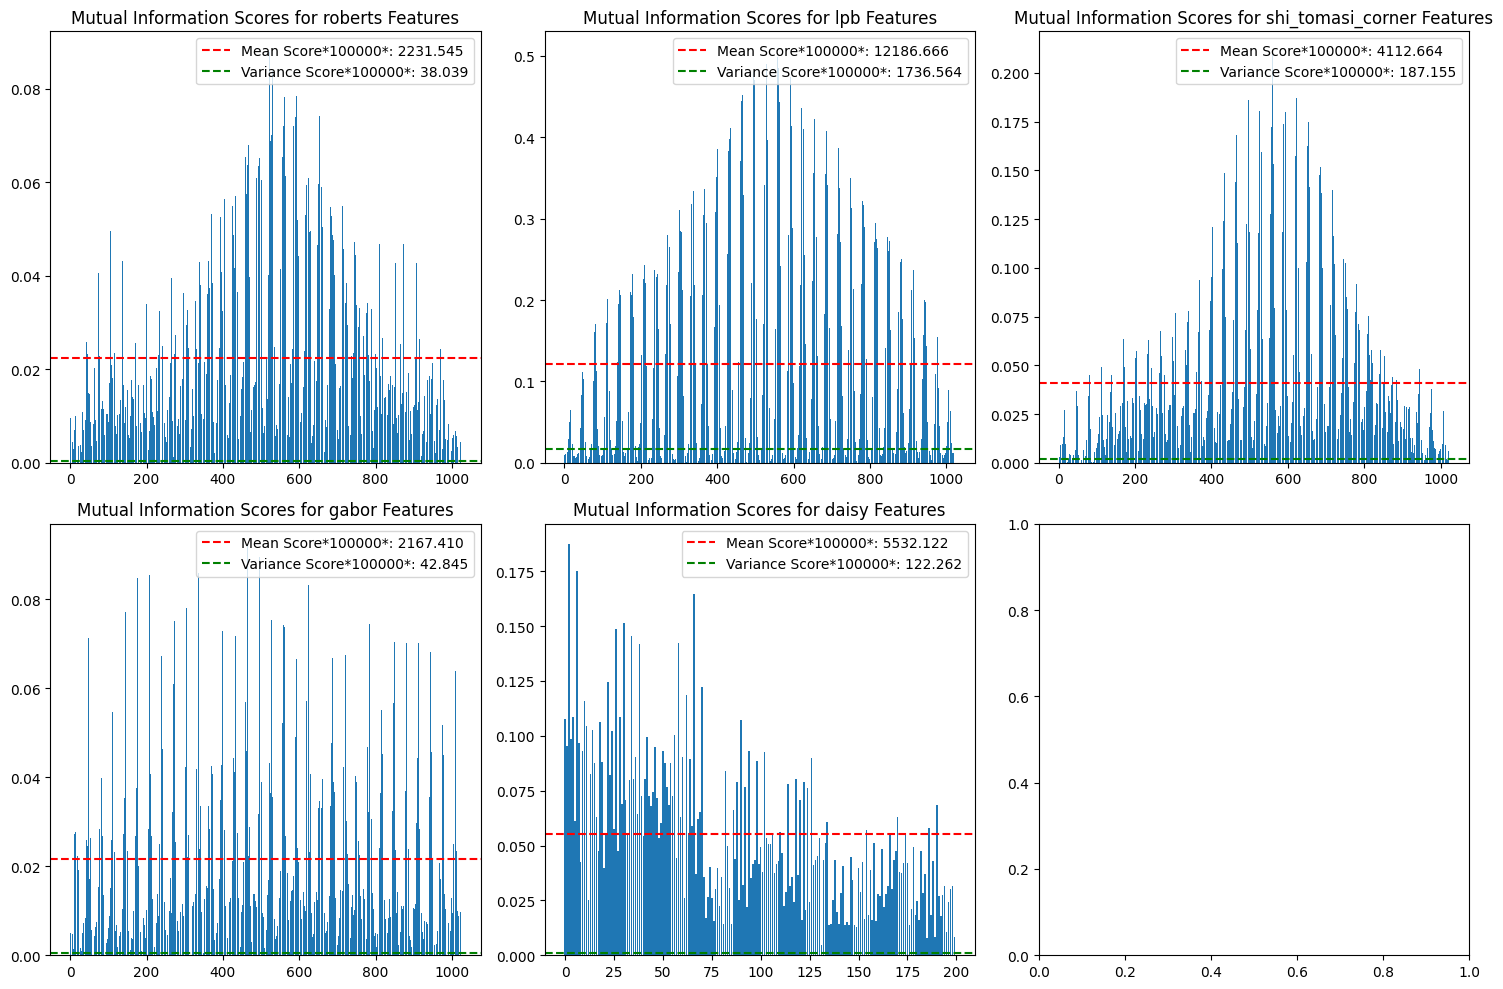

In [152]:
# print mutual information 
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
i = 0
for name in edge_dict_full:
    row = i // 3 
    col = i % 3   
    i += 1
    axes[row, col].bar(range(len(edge_dict_full[name]["mi"])), edge_dict_full[name]["mi"])
    axes[row, col].axhline(y=edge_dict_full[name]["mean"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict_full[name]["mean"]:.3f}')
    axes[row, col].axhline(y=edge_dict_full[name]["var"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict_full[name]["var"]:.3f}')
    axes[row, col].legend()
    axes[row, col].set_title("Mutual Information Scores for " + name  + " Features")

plt.tight_layout()
plt.show()

In [153]:
# Remove features lower then their respective mean
for name in edge_dict_full:
    print ("For "+ name)
    print ("    Previous size is: " + str (edge_dict_full[name]["fv_red"].shape[1]))
    edge_dict_full[name]["fv_red"] =  edge_dict_full[name]["fv_red"] [:,edge_dict_full[name]["mi"] >= edge_dict_full[name]["mean"]]
    print ("    Reduced size is: " + str (edge_dict_full[name]["fv_red"].shape[1]))


For roberts
    Previous size is: 1024
    Reduced size is: 351
For lpb
    Previous size is: 1024
    Reduced size is: 398
For shi_tomasi_corner
    Previous size is: 1024
    Reduced size is: 315
For gabor
    Previous size is: 1024
    Reduced size is: 384
For daisy
    Previous size is: 200
    Reduced size is: 83


In [154]:
# Calculate mutual info again
for name in edge_dict_full:
    edge_dict_full[name]["mi2"] = mutual_info_classif(edge_dict_full[name]["fv_red"], train_labels)
    edge_dict_full[name]["mean2"] = np.mean(edge_dict_full[name]["mi2"])
    edge_dict_full[name]["var2"] = np.var(edge_dict_full[name]["mi2"])


/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig()

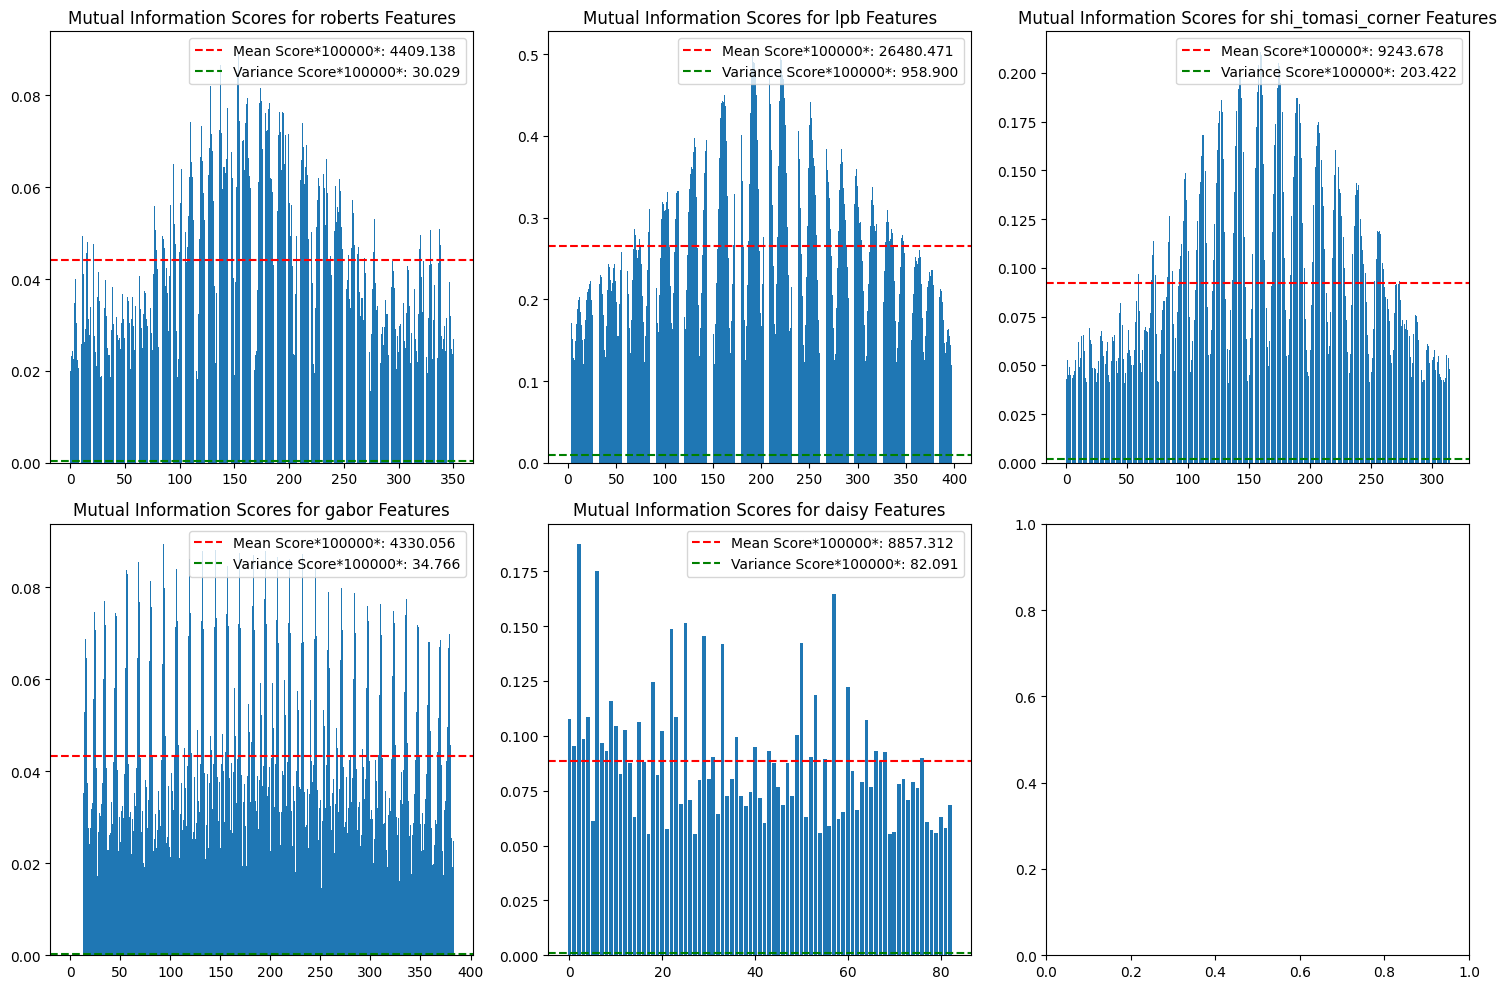

In [155]:
# print reduced mutual information 
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
i = 0
for name in edge_dict_full:
    row = i // 3 
    col = i % 3   
    i += 1
    axes[row, col].bar(range(len(edge_dict_full[name]["mi2"])), edge_dict_full[name]["mi2"])
    axes[row, col].axhline(y=edge_dict_full[name]["mean2"], color='red', linestyle='--', label=f'Mean Score*100000*: {100000*edge_dict_full[name]["mean2"]:.3f}')
    axes[row, col].axhline(y=edge_dict_full[name]["var2"], color='green', linestyle='--', label=f'Variance Score*100000*: {100000*edge_dict_full[name]["var2"]:.3f}')
    axes[row, col].legend()
    axes[row, col].set_title("Mutual Information Scores for " + name  + " Features")

plt.tight_layout()
plt.show()

In [156]:
# remove unneeded variables to save ram 
for name in edge_dict_full:
    edge_dict_full [name]["fv_red"] =  np.round(edge_dict_full [name]["fv_red"], decimals=3) 
        

## 2.3 Intra-inter Class

In [4]:
for name in edge_dict_full:
    print(name)

# Calculate intra-class and inter-class masks from labels
class_masks = [np.array([], dtype=int) for _ in range(11)]
for i in range(len(train_labels)):      
    class_masks[train_labels[i]] = np.round(np.append(class_masks [train_labels[i]], i), decimals=3)



roberts
lpb
shi_tomasi_corner
gabor
daisy


In [ ]:
# calculate euclidean distance matrix for roberts
name="roberts"
edge_dict_full[name]["distance_matrix"] = pairwise_distances(edge_dict_full[name]["fv_red"], metric='euclidean') 
# A distance matrix D such that D_{i, j} is the distance between the ith and jth vectors

# Loop over data dimensions and create text annotations.
class_distances = np.zeros((10,10))
for i in range(1,11):
    for j in range(1,11):
        class_distances[i-1][j-1] = np.round(np.mean(edge_dict_full[name]["distance_matrix"][class_masks[i]][:, class_masks[j]]), decimals=3 )
        
print ("Distance Matrix of "+ name)
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(class_distances, cmap="coolwarm")
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(10)+1)
ax.set_yticklabels(np.arange(10)+1)

# Loop over data dimensions and create text annotations.
for i in range(0,10):
    for j in range(0,10):
        text = ax.text(j, i, class_distances[i-1][j-1],ha="center", va="center", color="w")

ax.set_title("Class Distance Heatmap of " + name)
plt.show()    
# make distance matrix empty again tor educe ram
edge_dict_full[name]["distance_matrix"]= []

In [ ]:
# calculate euclidean distance matrix for lpb
name="lpb"
edge_dict_full[name]["distance_matrix"] = pairwise_distances(edge_dict_full[name]["fv_red"], metric='euclidean') 
# A distance matrix D such that D_{i, j} is the distance between the ith and jth vectors

# Loop over data dimensions and create text annotations.
class_distances = np.zeros((10,10))
for i in range(1,11):
    for j in range(1,11):
        class_distances[i-1][j-1] = np.round(np.mean(edge_dict_full[name]["distance_matrix"][class_masks[i]][:, class_masks[j]]), decimals=3 )
        
print ("Distance Matrix of "+ name)
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(class_distances, cmap="coolwarm")
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(10)+1)
ax.set_yticklabels(np.arange(10)+1)

# Loop over data dimensions and create text annotations.
for i in range(0,10):
    for j in range(0,10):
        text = ax.text(j, i, class_distances[i-1][j-1],ha="center", va="center", color="w")

ax.set_title("Class Distance Heatmap of " + name)
plt.show()    
# make distance matrix empty again tor educe ram
edge_dict_full[name]["distance_matrix"]= []

In [ ]:
# calculate euclidean distance matrix for shi_tomasi_corner
name="shi_tomasi_corner"
edge_dict_full[name]["distance_matrix"] = pairwise_distances(edge_dict_full[name]["fv_red"], metric='euclidean') 
# A distance matrix D such that D_{i, j} is the distance between the ith and jth vectors

# Loop over data dimensions and create text annotations.
class_distances = np.zeros((10,10))
for i in range(1,11):
    for j in range(1,11):
        class_distances[i-1][j-1] = np.round(np.mean(edge_dict_full[name]["distance_matrix"][class_masks[i]][:, class_masks[j]]), decimals=3 )
        
print ("Distance Matrix of "+ name)
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(class_distances, cmap="coolwarm")
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(10)+1)
ax.set_yticklabels(np.arange(10)+1)

# Loop over data dimensions and create text annotations.
for i in range(0,10):
    for j in range(0,10):
        text = ax.text(j, i, class_distances[i-1][j-1],ha="center", va="center", color="w")

ax.set_title("Class Distance Heatmap of " + name)
plt.show()    
# make distance matrix empty again tor educe ram
edge_dict_full[name]["distance_matrix"]= []

In [ ]:
# calculate euclidean distance matrix for gabor
name="gabor"
edge_dict_full[name]["distance_matrix"] = pairwise_distances(edge_dict_full[name]["fv_red"], metric='euclidean') 
# A distance matrix D such that D_{i, j} is the distance between the ith and jth vectors

# Loop over data dimensions and create text annotations.
class_distances = np.zeros((10,10))
for i in range(1,11):
    for j in range(1,11):
        class_distances[i-1][j-1] = np.round(np.mean(edge_dict_full[name]["distance_matrix"][class_masks[i]][:, class_masks[j]]), decimals=3 )
        
print ("Distance Matrix of "+ name)
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(class_distances, cmap="coolwarm")
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(10)+1)
ax.set_yticklabels(np.arange(10)+1)

# Loop over data dimensions and create text annotations.
for i in range(0,10):
    for j in range(0,10):
        text = ax.text(j, i, class_distances[i-1][j-1],ha="center", va="center", color="w")

ax.set_title("Class Distance Heatmap of " + name)
plt.show()    
# make distance matrix empty again tor educe ram
edge_dict_full[name]["distance_matrix"]= []

Distance Matrix of daisy


/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/tutel/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig()

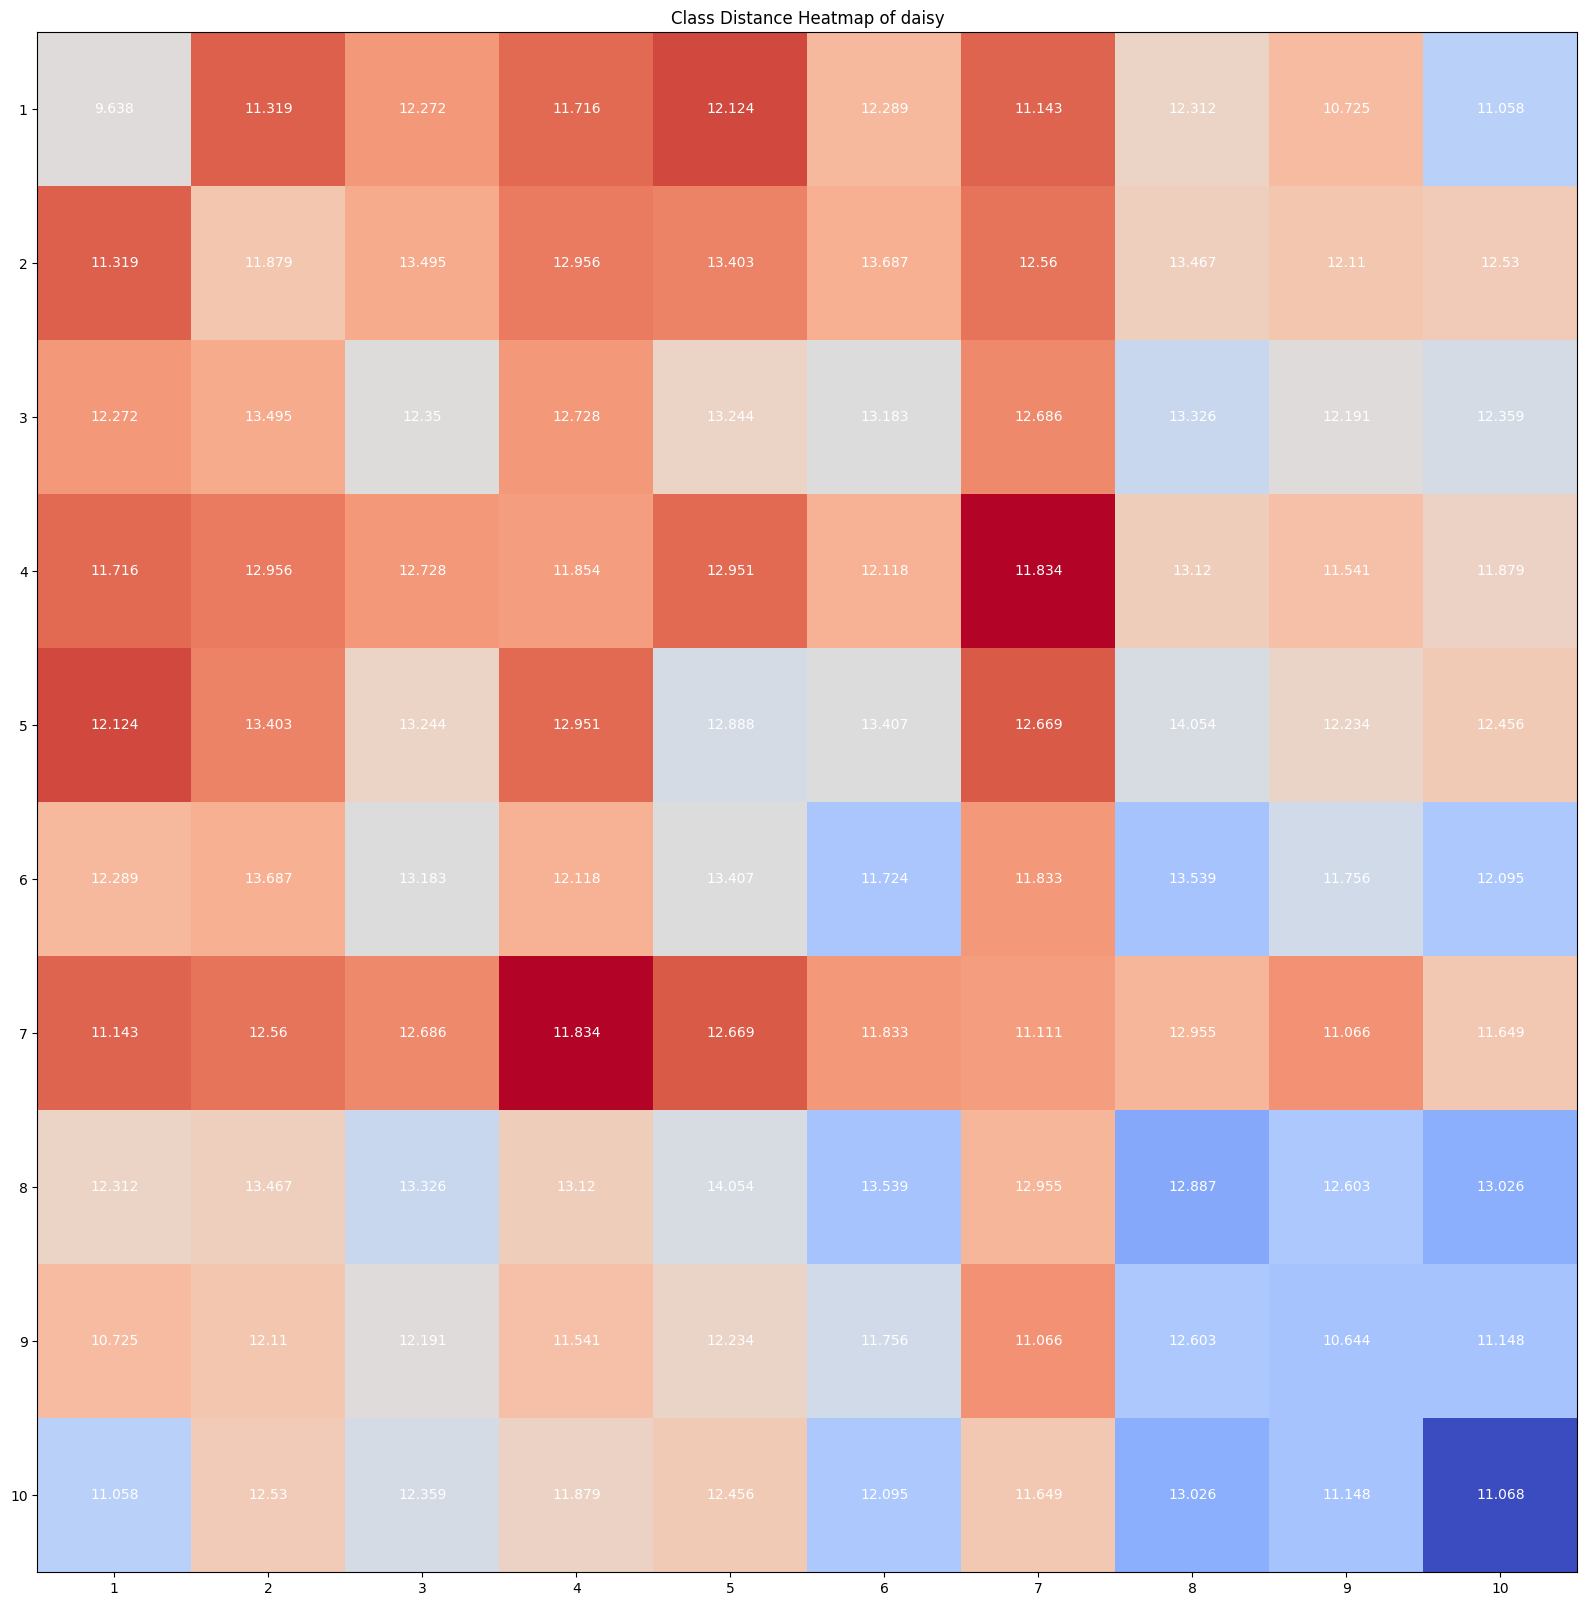

In [6]:
# calculate euclidean distance matrix for daisy
name="daisy"
edge_dict_full[name]["distance_matrix"] = pairwise_distances(edge_dict_full[name]["fv_red"], metric='euclidean') 
# A distance matrix D such that D_{i, j} is the distance between the ith and jth vectors

# Loop over data dimensions and create text annotations.
class_distances = np.zeros((10,10))
for i in range(1,11):
    for j in range(1,11):
        class_distances[i-1][j-1] = np.round(np.mean(edge_dict_full[name]["distance_matrix"][class_masks[i]][:, class_masks[j]]), decimals=3 )
        
print ("Distance Matrix of "+ name)
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(class_distances, cmap="coolwarm")
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(10)+1)
ax.set_yticklabels(np.arange(10)+1)

# Loop over data dimensions and create text annotations.
for i in range(0,10):
    for j in range(0,10):
        text = ax.text(j, i, class_distances[i-1][j-1],ha="center", va="center", color="w")

ax.set_title("Class Distance Heatmap of " + name)
plt.show()    
# make distance matrix empty again tor educe ram
edge_dict_full[name]["distance_matrix"]= []

# 3 Classification

In [167]:
# save values
import dill
dill.dump_session('notebook_train.db')

In [300]:
# save values
import dill
dill.dump_session('notebook_pipe.db')

In [191]:
# load values
import dill
dill.load_session('notebook_train.db')

## Prepare test data

In [329]:
## Prepare test data
edge_dict_test = {}

# roberts operator edge detector
name = "roberts"
edge_dict_test[name] = {"fv" : [] } 


@adapt_rgb(as_gray)
def roberts_gray(image):
    return filters.roberts(image)

def roberts(image):
    return roberts_gray(to_greyscale((image))).flatten()

print (name + " operator edge detector")

for i in range(test_labels.size):
    edge_dict_test[name]["fv"].append(roberts(test_images[:,:,:,i]))

# ----------------------------------------------------------------------------------------------------------------
# lpb  local binary pattern
radius_of_circle = 3 #     Radius of circle (spatial resolution of the operator).
no_of_neighbor_set_points = 9  * radius_of_circle # Number of circularly symmetric neighbor set points (quantization of the angular space).
name = "lpb"
edge_dict_test[name] = {"fv" : [] } 


@adapt_rgb(as_gray)
def lpb_gray(image):
    return feature.local_binary_pattern(image, no_of_neighbor_set_points, radius_of_circle, method='default')

def lpb(image):
    return lpb_gray(to_greyscale((image))).flatten()

print (name + "  image detector")

for i in range(test_labels.size):
    edge_dict_test[name]["fv"].append(lpb(test_images[:,:,:,i]))

# ----------------------------------------------------------------------------------------------------------------
# Compute Shi-Tomasi (Kanade-Tomasi) corner measure response image
sigma=1
name = "shi_tomasi_corner"
edge_dict_test[name] = {"fv" : [] } 


@adapt_rgb(as_gray)
def shi_tomasi_corner_gray(image):
    return feature.corner_shi_tomasi(image, sigma)

def shi_tomasi_corner(image):
    return shi_tomasi_corner_gray(to_greyscale((image))).flatten()


print (name + "  image detector")

for i in range(test_labels.size):
    edge_dict_test[name]["fv"].append(shi_tomasi_corner(test_images[:,:,:,i]))



# ----------------------------------------------------------------------------------------------------------------

# gabor  filter
name = "gabor"
edge_dict_test[name] = {"fv" : [] } 



@adapt_rgb(as_gray)
def gabor_gray(image):
    show_image_real,show_image_imaginary = filters.gabor(image, frequency=0.1)
    return show_image_real

def gabor(image):
    return gabor_gray(to_greyscale((image))).flatten()

print (name + "  image detector")

for i in range(test_labels.size):
    edge_dict_test[name]["fv"].append(gabor(test_images[:,:,:,i]))


# ----------------------------------------------------------------------------------------------------------------
# daisy
name = "daisy"
edge_dict_test[name] = {"fv" : [] } 


@adapt_rgb(as_gray)
def daisy_gray(image):
    return feature.daisy(image, visualize=False)

def daisy(image):
    return daisy_gray(to_greyscale((image))).flatten()


print (name + "  image detector")

for i in range(test_labels.size):
    edge_dict_test[name]["fv"].append(daisy(test_images[:,:,:,i]))
# ----------------------------------------------------------------------------------------------------------------

# round features
test_fv = {}
for name in edge_dict_test:
    edge_dict_test [name]["fv"] =  np.round(edge_dict_test [name]["fv"], decimals=3) 
    test_fv[name] = edge_dict_test [name]["fv"] 
    edge_dict_test[name]["fv"] = []

test_pandas = pd.DataFrame({f'{key}_{i}': data[:, i] for key, data in test_fv.items() for i in range(data.shape[1])})


roberts operator edge detector
lpb  image detector
shi_tomasi_corner  image detector
gabor  image detector
daisy  image detector


In [299]:
test_pandas

,roberts_0,roberts_1,roberts_2,roberts_3,roberts_4,roberts_5,roberts_6,roberts_7,roberts_8,roberts_9,...,daisy_190,daisy_191,daisy_192,daisy_193,daisy_194,daisy_195,daisy_196,daisy_197,daisy_198,daisy_199
0,0.003,0.000,0.003,0.003,0.003,0.003,0.000,0.000,0.000,0.000,...,0.004,0.003,0.003,0.003,0.004,0.003,0.003,0.003,0.003,0.002
1,0.026,0.024,0.026,0.028,0.027,0.027,0.029,0.029,0.026,0.021,...,0.007,0.005,0.005,0.004,0.003,0.003,0.003,0.004,0.006,0.005
2,0.008,0.016,0.016,0.019,0.012,0.017,0.028,0.020,0.010,0.022,...,0.002,0.003,0.005,0.006,0.005,0.003,0.004,0.004,0.003,0.003
3,0.021,0.019,0.027,0.040,0.034,0.035,0.040,0.041,0.037,0.035,...,0.004,0.003,0.001,0.001,0.002,0.002,0.002,0.003,0.004,0.002
4,0.000,0.000,0.000,0.000,0.003,0.009,0.009,0.011,0.011,0.011,...,0.002,0.002,0.001,0.003,0.006,0.007,0.005,0.004,0.003,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26027,0.008,0.010,0.011,0.011,0.008,0.004,0.006,0.010,0.018,0.025,...,0.004,0.004,0.004,0.006,0.007,0.006,0.004,0.004,0.005,0.004
26028,0.008,0.006,0.004,0.006,0.010,0.000,0.010,0.014,0.019,0.022,...,0.004,0.003,0.004,0.005,0.006,0.005,0.003,0.004,0.005,0.004
26029,0.028,0.028,0.026,0.022,0.016,0.012,0.010,0.011,0.006,0.004,...,0.006,0.004,0.002,0.002,0.005,0.004,0.004,0.004,0.005,0.003
26030,0.004,0.000,0.006,0.006,0.006,0.004,0.000,0.000,0.004,0.004,...,0.005,0.004,0.003,0.002,0.002,0.003,0.005,0.007,0.007,0.004


## Prepare train data

In [ ]:
# round features
test_fv = {}
for name in edge_dict_full:
    edge_dict_full [name]["fv"] =  np.round(edge_dict_full [name]["fv"], decimals=3) 
    test_fv[name] = edge_dict_full [name]["fv"] 
    edge_dict_full[name]["fv"] = []

test_pandas = pd.DataFrame({f'{key}_{i}': data[:, i] for key, data in test_fv.items() for i in range(data.shape[1])})
del test_fv

In [287]:
train_pandas

,roberts_0,roberts_1,roberts_2,roberts_3,roberts_4,roberts_5,roberts_6,roberts_7,roberts_8,roberts_9,...,daisy_190,daisy_191,daisy_192,daisy_193,daisy_194,daisy_195,daisy_196,daisy_197,daisy_198,daisy_199
0,0.052,0.012,0.094,0.088,0.024,0.011,0.043,0.024,0.011,0.008,...,0.003,0.004,0.009,0.007,0.005,0.005,0.007,0.006,0.004,0.005
1,0.006,0.019,0.046,0.089,0.124,0.078,0.000,0.078,0.095,0.016,...,0.003,0.004,0.003,0.002,0.001,0.003,0.004,0.003,0.002,0.002
2,0.006,0.020,0.004,0.009,0.011,0.012,0.026,0.062,0.072,0.092,...,0.009,0.005,0.007,0.005,0.004,0.004,0.007,0.008,0.006,0.006
3,0.037,0.055,0.071,0.104,0.115,0.075,0.047,0.034,0.020,0.011,...,0.009,0.006,0.005,0.003,0.002,0.001,0.002,0.003,0.005,0.006
4,0.012,0.035,0.024,0.012,0.004,0.008,0.008,0.016,0.004,0.010,...,0.003,0.005,0.007,0.009,0.011,0.007,0.004,0.003,0.005,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73252,0.006,0.006,0.009,0.008,0.006,0.009,0.006,0.006,0.006,0.009,...,0.007,0.005,0.005,0.004,0.003,0.003,0.005,0.005,0.006,0.006
73253,0.003,0.006,0.006,0.003,0.004,0.000,0.003,0.003,0.006,0.006,...,0.007,0.005,0.003,0.002,0.002,0.001,0.001,0.002,0.004,0.004
73254,0.010,0.075,0.138,0.161,0.037,0.009,0.017,0.062,0.037,0.010,...,0.002,0.004,0.005,0.006,0.003,0.003,0.007,0.006,0.003,0.003
73255,0.066,0.064,0.036,0.009,0.020,0.019,0.012,0.008,0.019,0.018,...,0.004,0.003,0.002,0.003,0.004,0.004,0.003,0.004,0.003,0.003


## Create a template ColumnTransformer 

In [307]:
# Creat e a pipeline
class SelectAboveMeanFeatures(TransformerMixin):
    def __init__(self, name="None"):
        self.name = name

    def fit(self, X,y):        
        #print("fit of " + self.name )
        #print (X.shape , y.shape)
        mi = mutual_info_classif(X, y)
        mean = np.mean(mi)       
        self.selected_indices = np.where( mi >= mean)[0]   
        return self

    def transform(self, X):    
        #print("transform of " + self.name )
        #print (X.shape )
        return X[:,self.selected_indices]

for name in train_fv:
    pipelines [name] = make_pipeline(
        # StandardScaler
        StandardScaler(), 
        # Mutua l information feature selection
        SelectAboveMeanFeatures(name),
    )

    # new_pipeline = Pipeline(steps=[
    #    ('pipeline', pipeline),
    #    ('custom_function', FunctionTransformer(custom_function))
    #])

combined_pipeline = []
for name in train_fv:
    combined_pipeline.append ((name, pipelines [name], make_column_selector(pattern = "^" + name + "_") ) )
    
combined_pipeline =  ColumnTransformer(
    transformers=combined_pipeline)     



In [292]:
combined_pipeline

ColumnTransformer(transformers=[('roberts',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('selectabovemeanfeatures',
                                                  <__main__.SelectAboveMeanFeatures object at 0x7facda1d09d0>)]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7facda16e490>),
                                ('lpb',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('selectabovemeanfeatures',...
                                                  <__main__.SelectAboveMeanFeatures object at 0x7facdc576510>)]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7facdc574fd0>),
                                ('daisy',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('selectabovemeanfeatures',
                                                  <__main__.SelectAboveMeanFeatures object at 0x7facdc577650>)]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7facdc5776d0>)])

## Knn Classifier

In [296]:
knn_pipeline = make_pipeline( combined_pipeline ,  KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree'))


In [242]:
knn_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('roberts',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('selectabovemeanfeatures',
                                                                   <__main__.SelectAboveMeanFeatures object at 0x7fb1b0093550>)]),
                                                  ['roberts']),
                                                 ('lpb',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('selectabovemeanfeatures',
                                                                   <__main__.SelectAboveMeanFeature...
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('selectabovemeanfeatures',
                                                                   <__main__.SelectAboveMeanFeatures object at 0x7fb1b0093f10>)]),
                                                  ['gabor']),
                                                 ('daisy',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('selectabovemeanfeatures',
                                                                   <__main__.SelectAboveMeanFeatures object at 0x7fb1b0092e10>)]),
                                                  ['daisy'])])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='kd_tree'))])

In [305]:
knn_pipeline.fit(train_pandas  ,train_labels)

fit of roberts
(73257, 1024) (73257,)
transform of roberts
(73257, 1024)
fit of lpb
(73257, 1024) (73257,)
transform of lpb
(73257, 1024)
fit of shi_tomasi_corner
(73257, 1024) (73257,)
transform of shi_tomasi_corner
(73257, 1024)
fit of gabor
(73257, 1024) (73257,)
transform of gabor
(73257, 1024)
fit of daisy
(73257, 200) (73257,)
transform of daisy
(73257, 200)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('roberts',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('selectabovemeanfeatures',
                                                                   <__main__.SelectAboveMeanFeatures object at 0x7facd9ede410>)]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7facd9d7ab90>),
                                                 ('lpb',
                                                  Pipeline(steps=[('standardscaler',
                                                                   Standard...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7facd9d7b590>),
                                                 ('daisy',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('selectabovemeanfeatures',
                                                                   <__main__.SelectAboveMeanFeatures object at 0x7facd9d79110>)]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7facd9d78f50>)])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='kd_tree'))])

In [306]:
knn_pipeline.score(test_pandas  ,test_labels)

transform of roberts
(26032, 1024)
transform of lpb
(26032, 1024)
transform of shi_tomasi_corner
(26032, 1024)
transform of gabor
(26032, 1024)
transform of daisy
(26032, 200)


0.7269130301167793

## Linear - Support Vector Machine (SVM) Linear Kernel:

In [330]:
test_pandas_backup = test_pandas
test_pandas = test_pandas.drop(range(26031,10000,-1))

In [338]:
test_labels_backup = test_labels
test_labels = test_labels[range(0,10001,1)]

(10001,)

In [324]:
svm = SVC(kernel='linear', probability=True, max_iter=1000, random_state=42)
svm_pipeline = make_pipeline( combined_pipeline ,  svm)

# Hyperparameter tuning 
from sklearn.model_selection import RandomizedSearchCV
hyperparameter_grid = {
    'svc__C': np.logspace(-3, 3, 7)          # Regularization parameter
}


random_search = RandomizedSearchCV(svm_pipeline, param_distributions=hyperparameter_grid, n_iter=10, cv=5, random_state=42, verbose=2, n_jobs=-1).fit(train_pandas  ,train_labels)

print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/tutel/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [341]:
svm = SVC(kernel='linear', probability=True, max_iter=1000, random_state=42)

decision_function_scores = []

for epoch in range(1, 1001,250):
    print ("epoch : " + str (epoch))
    svm.set_params(max_iter=epoch)
    svm_pipeline = make_pipeline( combined_pipeline ,  svm)
    svm_pipeline.fit(train_pandas  ,train_labels)
    print ("epoch fit : " + str (epoch))
    decision_function_scores.append(svm_pipeline.score(test_pandas  ,test_labels))
    print (" score of epoch " + str (epoch) + " is " + str(decision_function_scores))

plt.plot(range(1, 1001,250), decision_function_scores)
plt.xlabel('Iteration/Epoch')
plt.ylabel('Decision Function Score')
plt.title('Convergence of SVM with Linear Kernel')
plt.show()


epoch : 1


/home/tutel/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


epoch fit : 1
 score of epoch 1 is [0.10578942105789421]
epoch : 251


/home/tutel/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=251).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


epoch fit : 251
 score of epoch 251 is [0.10578942105789421, 0.3581641835816418]
epoch : 501


# 3 Metric Learning

## SIFT

In [ ]:
import cv2

sift = cv2.SIFT_create()

sift_descriptors = []
for i in range(len(train_labels)):
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(to_greyscale(train_images[:,:,:,i]), None)
    
    print(descriptors.shape)
    # If descriptors are found, append to the list
    if descriptors is not None:
        sift_descriptors.append(descriptors)
    else:
        sift_descriptors.append([])  # Append an empty list if no descriptors are found

sift_descriptors = np.array(sift_descriptors)
# image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)


In [ ]:
import torch.nn as nn

# define loss_function 
def loss_function(feature_vectors, labels):
    num_samples = len(feature_vectors)
    
    # Calculate pairwise distances
    distances = pairwise_distances(feature_vectors, metric='euclidean')

    # Initialize the loss
    loss = 0.0

    # Iterate over all pairs of samples
    for i in range(num_samples):
        for j in range(i+1,num_samples):
            if labels[i] == labels[j]:
                loss += distances[i, j]
            else:
                loss -= distances[i, j]

    return loss


input_dim = sift_descriptors.shape
output_dim = input_dim//2
projection_matrix = nn.Linear(input_dim, output_dim)

